# Trilegal priors to HATS

Objective: Convert directory of numpy files into a HATS map catalog

## Step 1 - `.npy` to `.parquet`

We start with

- unpacking the numpy files into parquet tables
- adding HATS-specfic columns
- saving with name consistent with HATS expected directories

In [1]:
import numpy as np
from pathlib import Path


prior_np_dir = Path("/mnt/beegfs/scratch/data/priors/TRILEGAL/S82/5")
healpix_order = 5

In [2]:
# destination_dir = Path("/home/delucchi/git/goofing/priors")
destination_dir = Path("/mnt/beegfs/scratch/data/priors/testing")
(destination_dir / "dataset" / "Norder=5" / "Dir=0").mkdir(parents=True, exist_ok=True)
(destination_dir / "dataset" / "Norder=5" / "Dir=10000").mkdir(
    parents=True, exist_ok=True
)

In [3]:
pixel_list = [
    0,
    1,
    2,
    3072,
    3073,
    3074,
    4349,
    4350,
    4351,
    4413,
    4414,
    4415,
    4429,
    4430,
    4431,
    4433,
    4434,
    4435,
    4436,
    4437,
    4438,
    4439,
    4440,
    4441,
    4442,
    4443,
    4444,
    4445,
    4446,
    4449,
    4450,
    4451,
    4452,
    4453,
    4454,
    4455,
    4456,
    4457,
    4458,
    4459,
    4460,
    4461,
    4462,
    4464,
    4465,
    4466,
    4493,
    4494,
    4495,
    4497,
    4498,
    4499,
    4500,
    4501,
    4502,
    4503,
    4504,
    4505,
    4506,
    4507,
    4508,
    4509,
    4510,
    4513,
    4514,
    4515,
    4516,
    4517,
    4518,
    4519,
    4520,
    4521,
    4522,
    4523,
    4524,
    4525,
    4526,
    4528,
    4529,
    4530,
    4544,
    4545,
    4546,
    4669,
    4670,
    4671,
    4685,
    4686,
    4687,
    4689,
    4690,
    4691,
    4692,
    4693,
    4694,
    4695,
    4696,
    4697,
    4698,
    4699,
    4700,
    4701,
    4702,
    4705,
    4706,
    4707,
    4708,
    4709,
    4710,
    4711,
    4712,
    4713,
    4714,
    4715,
    4716,
    4717,
    4718,
    4720,
    4721,
    4722,
    4749,
    4750,
    4751,
    4753,
    4754,
    4755,
    4756,
    4757,
    4758,
    4759,
    4760,
    4761,
    4762,
    4763,
    4764,
    4765,
    4766,
    4769,
    4770,
    4771,
    4772,
    4773,
    4774,
    4775,
    4776,
    4777,
    4778,
    4779,
    4780,
    4781,
    4782,
    4784,
    4785,
    4786,
    4800,
    4801,
    4802,
    4864,
    4865,
    4866,
    5773,
    5774,
    5775,
    5778,
    5779,
    5784,
    5785,
    5786,
    5787,
    5788,
    5790,
    5793,
    5794,
    5795,
    5796,
    5797,
    5798,
    5799,
    5800,
    5801,
    5802,
    5803,
    5804,
    5805,
    5806,
    5808,
    5809,
    5810,
    7505,
    7506,
    7507,
    7508,
    7509,
    7510,
    7511,
    7512,
    7513,
    7515,
    7516,
    7517,
    7518,
    9213,
    9214,
    9215,
    12285,
    12286,
    12287,
]


In [4]:
import pyarrow as pa
import pyarrow.parquet as pq
from hats.pixel_math import HealpixPixel


rGrid = np.linspace(14, 27, 27)
for pix in pixel_list:
    kdes = []
    xGrids = []
    yGrids = []

    for rind, r in enumerate(rGrid):
        file_name = prior_np_dir / f"{pix}-{rind:02d}.npz"
        prior_contents = np.load(file_name)
        kdes.append(prior_contents["kde"].flatten())
        xGrids.append(prior_contents["xGrid"].flatten())
        yGrids.append(prior_contents["yGrid"].flatten())

    healpixel = HealpixPixel(healpix_order, pix)

    table = pa.Table.from_arrays(
        [
            rGrid,
            kdes,
            xGrids,
            yGrids,
            np.full(len(rGrid), fill_value=healpixel.order, dtype=np.int8),
            np.full(len(rGrid), fill_value=healpixel.dir, dtype=np.int64),
            np.full(len(rGrid), fill_value=healpixel.pixel, dtype=np.int64),
            np.full(
                len(rGrid),
                fill_value=healpixel.pixel * (4 ** (29 - healpixel.order)),
                dtype=np.int64,
            ),
        ],
        names=["rmag", "kde", "xGrid", "yGrid", "Norder", "Dir", "Npix", "_healpix_29"],
    )

    hats_file = (
        destination_dir
        / "dataset"
        / f"Norder={healpixel.order}"
        / f"Dir={healpixel.dir}"
        / f"Npix={healpixel.pixel}.parquet"
    )
    pq.write_table(table, hats_file)

## Step 2 - add HATS metadata files

In [5]:
import hats.io.file_io as io
from hats.catalog import PartitionInfo
from hats.io import paths
from hats.io.parquet_metadata import write_parquet_metadata

from hats.catalog import TableProperties
from pathlib import Path

from datetime import datetime, timezone
import numpy as np

parquet_rows = write_parquet_metadata(destination_dir)

# Read partition info from _metadata and write to partition_info.csv
partition_info = PartitionInfo.read_from_dir(destination_dir)
partition_info_file = paths.get_partition_info_pointer(destination_dir)
partition_info.write_to_file(partition_info_file)

now = datetime.now(tz=timezone.utc)

catalog_info = TableProperties(
    catalog_name="testing",
    total_rows=parquet_rows,
    hats_order=5,
    hats_builder="LP",
    hats_creation_date=now.strftime("%Y-%m-%dT%H:%M%Z"),
    catalog_type="map",
    ra_column=None,
    dec_column=None,
)
catalog_info.to_properties_file(destination_dir)

## Step 3 - make sure it's "ok"

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - testing'}>)

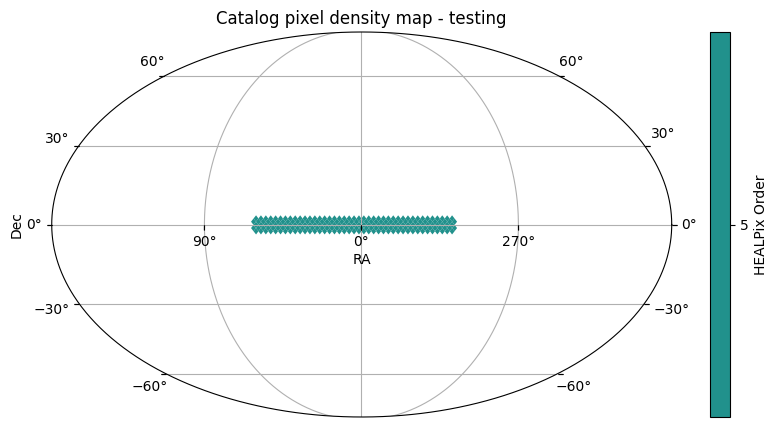

In [6]:
from hats import read_hats

catalog = read_hats(destination_dir)
catalog.plot_pixels()